In [1]:
using PyCall
using Distances
using StatsBase
using LinearAlgebra
using JuMP
using Gurobi
using CSV
using Distances
using PyPlot
using SparseArrays
using Printf
using Images

In [2]:
py"""
import numpy as np
import cv2

class RootSIFT:
    def __init__(self):
        self.extractor = cv2.xfeatures2d.SIFT_create()

    def compute(self, image, kps, eps=1e-7):
        (kps, descs) = self.extractor.compute(image, kps)
        if len(kps) == 0:
            return ([], None)

        descs /= (descs.sum(axis=1, keepdims=True) + eps)
        descs = np.sqrt(descs)
        return (kps, descs)
def rootSIFT(img_path, resize = False, scale = 50):
    image = cv2.imread(img_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    if resize:  # percent of original size
        width = int(gray.shape[1] * scale / 100)
        height = int(gray.shape[0] * scale / 100)
        dim = (width, height)
        gray = cv2.resize(gray, dim, interpolation = cv2.INTER_AREA)

    sift = cv2.xfeatures2d.SIFT_create()
    (kps, descs) = sift.detectAndCompute(gray, None)
    rs = RootSIFT()
    (kps, descs) = rs.compute(gray, kps)
    pos = [np.array([x.pt[0], x.pt[1]]) for x in kps]

    return gray,np.array(pos)

"""

img1_path = "../data/test/001_L.png"
img2_path = "../data/test/001_R.png"

img1,descs1 = py"rootSIFT"(img1_path, true, scale = 5);
img2,descs2  = py"rootSIFT"(img2_path, true, scale = 5);

In [3]:
function cleaning(original)
    res_dict = Dict()
    for i in 1:size(original, 1)
        res_dict[hash(original[i,:])] = original[i,:]
    end
    
    vals = collect(values(res_dict))
    output = zeros(size(vals,1), 2)
    for i in 1:size(vals,1)
        output[i,:] = [vals[i][1],vals[i][2]]
    end
    
    return output
end

cleaning (generic function with 1 method)

In [119]:
P_points = cleaning(descs1);
Q_points = cleaning(descs2);

In [120]:
cost = pairwise(Euclidean(), P_points, Q_points; dims=1)

24×15 Array{Float64,2}:
  2.61316  11.1868    7.00503  30.8348   …  17.1272   17.3534   35.4664 
 10.9474   19.5943    1.4163   30.3281       8.77594  16.5053   38.6863 
 28.1241   34.5655   24.4111   11.1851      21.7474   10.9699   26.9405 
 39.0756   43.3279   37.9311    8.52203     36.8128   21.7427   20.6352 
 27.7907   28.785    31.2468   12.0848      35.3381   16.8037    7.06402
 32.2416   33.2718   35.3006   11.9227   …  38.7105   20.1008    4.56718
 27.0193   31.9963   25.7746    5.06907     25.7923    9.49905  19.9157 
 18.6642   27.3194    9.90619  27.576        3.28414  15.4411   39.2413 
 25.7319   32.65     21.3516   13.7668      18.3861    9.56624  28.7146 
  8.31735  16.7757    1.90974  31.6374      11.8754   17.7166   38.6789 
 14.5937   15.7062   19.9322   19.5943   …  26.7722   12.088    19.5717 
 41.6375   46.8343   39.06     12.9354      36.2631   23.8978   26.8731 
 11.0873    7.92785  19.6796   28.0416      28.7471   18.8207   26.1259 
 24.8758   30.8083   22.378

In [121]:
P = ones(size(P_points,1));
Q = ones(size(Q_points,1));

In [122]:
solCount = 10
# m = JuMP.direct_model(Gurobi.Optimizer(PoolSearchMode=2, PoolSolutions=solCount, SolutionNumber=0,PoolGap = 0.001))
m = JuMP.direct_model(Gurobi.Optimizer(PoolSearchMode=2, PoolSolutions=solCount, SolutionNumber=0))

@variable(m, X[axes(cost,1), axes(cost,2)] ≥ 0, Int)
@objective(m, Min, cost ⋅ X)
@constraint(m,sum(X) .== min(sum(P), sum(Q)))
@constraint(m, X * ones(Int, length(Q)) .<= P)
@constraint(m, X'ones(Int, length(P)) .<= Q);
optimize!(m)
solution_pool = zeros(solCount, length(P),length(Q))
cnt = 0
obj = objective_value(m)

for i in 0:(solCount-1)
    try
        setparam!(m.moi_backend.inner,"SolutionNumber", i)
        xn = Gurobi.get_dblattrarray(m.moi_backend.inner, "Xn", 1, length(X))
        xn_val = Gurobi.get_dblattr(m.moi_backend.inner, "PoolObjVal")
        if(round(xn_val,digits=1) != round(obj, digits=1))
            println(cnt , " solution(s) selected")
            break
        end
        default = zeros(length(P),length(Q))
        for i in 0:length(P)-1
            default[i+1,:] = xn[(i*length(Q))+1:(i+1)*length(Q)]
        end
        solution_pool[i+1,:,:] = default
        cnt+=1
    catch 
        break
    end
end
sol_pool = deepcopy(solution_pool[1:cnt,:,:]);

Optimize a model with 40 rows, 360 columns and 1080 nonzeros
Variable types: 0 continuous, 360 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+01]
Presolve time: 0.00s
Presolved: 40 rows, 360 columns, 1080 nonzeros
Variable types: 0 continuous, 360 integer (360 binary)

Root relaxation: objective 7.613365e+01, 29 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      76.1336532   76.13365  0.00%     -    0s
Optimal solution found at node 0 - now completing solution pool...
     0     0          -    0        76.13365   76.13365  0.00%     -    0s
     0     0          -    0        76.13365   76.13365  0.00%     -    0s
     0     2          -    0        76.13365   76.13365  0.00%     -    0s

Explored 1945

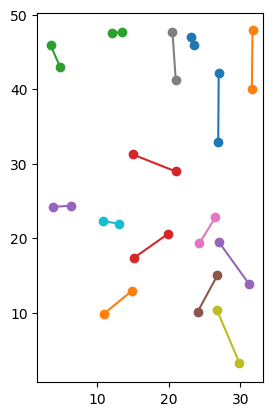

In [143]:
solOther = sparse(sol_pool[rand(1:cnt),:,:])
for (x,y,v) in zip(findnz(solOther)...)
    x_pos = [P_points'[:,x][1], Q_points'[:,y][1]]
    y_pos = [P_points'[:,x][2], Q_points'[:,y][2]]
    subplot(122)
    scatter(x_pos, y_pos)
    plot(x_pos, y_pos)
end